In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_classic, ggtitle, scale_color_manual

# Read in data
bp_to_sth = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB503HAWKS/data/mergeData/bp_to_sth_modelData.csv")

# Create target and predictor variables and split
X = bp_to_sth.drop(columns=['CONVERSION'])
y = bp_to_sth['CONVERSION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Define ct to standardize
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

In [52]:
pipeline_KNN = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsClassifier())
])
# Create grid for tuning
knn_params = {'regressor__n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(pipeline_KNN, knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Best KNN model
print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"Best Cross-Validation Accuracy: {knn_grid.best_score_:.4f}")

# Predictions
y_pred_knn = knn_grid.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = cm.ravel()

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)  # Sensitivity
specificity = tn / (tn + fp)  # True Negative Rate
f1 = f1_score(y_test, y_pred_knn)
roc_auc = roc_auc_score(y_test, y_pred_knn)

# Print Metrics
print("\nConfusion Matrix:\n", cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Best KNN parameters: {'regressor__n_neighbors': 5}
Best Cross-Validation Accuracy: 0.9897

Confusion Matrix:
 [[10807    33]
 [   88   287]]

Accuracy: 0.9892
Precision: 0.8969
Sensitivity: 0.7653
Specificity: 0.9970
F1 Score: 0.8259
ROC AUC Score: 0.8811


In [40]:
def significance_label(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ' '

In [58]:
import statsmodels.api as sm

pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression())
])

# Create grid for tuning
logreg_params = {'regressor__C': [1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='roc_auc')
logreg_grid.fit(X_train, y_train)

# Best LOGREG model
print(f"Best LOGREG parameters: {logreg_grid.best_params_}")
print(f"Best Cross-Validation Accuracy: {logreg_grid.best_score_:.4f}")

# Predictions
y_pred_logreg = logreg_grid.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
tn, fp, fn, tp = cm.ravel()

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)  # Sensitivity
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred_logreg)
roc_auc = roc_auc_score(y_test, y_pred_logreg)

# Print Metrics
print("\nConfusion Matrix:\n", cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Print coef
# Get best logistic regression model
best_logreg = logreg_grid.best_estimator_.named_steps['regressor']
# Extract coefficients
logreg_coef = best_logreg.coef_[0]
# Add an intercept to X_test
X_test_with_intercept = sm.add_constant(X_test)
# Fit using statsmodels to get p-values
model_sm = sm.Logit(y_test, X_test_with_intercept).fit(disp=0)
# Get p-values
p_values = model_sm.pvalues
# Create a DataFrame for better readability
coef_df = pd.DataFrame({
    "Coefficient": [best_logreg.intercept_[0]] + list(logreg_coef),
    "p-value": p_values
})
    
# Sort by significance
coef_df["Significance"] = coef_df["p-value"].apply(significance_label)
coef_df = coef_df.sort_values(by="p-value")
coef_df

Best LOGREG parameters: {'regressor__C': 1}
Best Cross-Validation Accuracy: 0.9808

Confusion Matrix:
 [[700  29]
 [ 36 339]]

Accuracy: 0.9411
Precision: 0.9212
Sensitivity: 0.9040
Specificity: 0.9602
F1 Score: 0.9125
ROC AUC Score: 0.9321


LinAlgError: Singular matrix

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))  # Remove features with high VIF (e.g., >10)


                             Feature       VIF
19                       no_purchase  1.855202
16                    0-200_purchase  1.813528
0                         email_send  1.615761
5                          page_view  1.599470
1                    form_submission  1.581433
17                  200-800_purchase  1.549927
2                   forward_received  1.516371
3                       forward_send  1.482428
10           primary_purchase_single  1.438351
18                     800+_purchase  1.408734
4                     merch_purchase  1.369863
13                    secondary_sale  1.359920
8              primary_purchase_club  1.291610
12                secondary_purchase  1.232564
14       text_incoming_from_customer  1.153540
15         text_outgoing_to_customer  1.130938
22          Avg_Engagement_per_visit  1.100536
20                      percent_open  1.048160
9                primary_purchase_ga  1.044256
7     phonecall_outgoing_to_customer  1.025651
6   phonecall

In [49]:
pipeline_tree = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeClassifier(random_state=42))
])

# Create grid for tuning
tree_params = {'regressor__max_depth': range(1, 11), 'regressor__min_samples_split': range(2, 10)}
tree_grid = GridSearchCV(pipeline_tree, tree_params, cv=5, scoring='roc_auc')
tree_grid.fit(X_train, y_train)

# Best tree model
print(f"Best tree parameters: {tree_grid.best_params_}")
print(f"Best Cross-Validation Accuracy: {tree_grid.best_score_:.4f}")

# Predictions
y_pred_tree = tree_grid.best_estimator_.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
tn, fp, fn, tp = cm.ravel()

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)  # Sensitivity
specificity = tn / (tn + fp)  # True Negative Rate
f1 = f1_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, y_pred_tree)

# Print Metrics
print("\nConfusion Matrix:\n", cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Decision Tree feature importance
# Access the DecisionTreeClassifier inside the pipeline
tree_model = tree_grid.best_estimator_.named_steps['regressor']

# Extract feature importance
tree_importance = tree_model.feature_importances_

# Print feature importance
print("\nDecision Tree Coefficients:")
for feature, importance in zip(features, tree_importance):
    print(f"{feature}: {importance}")

Best tree parameters: {'regressor__max_depth': 4, 'regressor__min_samples_split': 2}
Best Cross-Validation Accuracy: 0.9878

Confusion Matrix:
 [[10811    29]
 [  114   261]]

Accuracy: 0.9872
Precision: 0.9000
Sensitivity: 0.6960
Specificity: 0.9973
F1 Score: 0.7850
ROC AUC Score: 0.8467

Decision Tree Coefficients:
email_click: 0.7469194371611554
email_incoming_from_customer: 0.0
email_open: 0.0
email_outgoing_to_customer: 3.642800315652423e-05
email_send: 0.0
email_sub: 0.0
email_unsub: 0.0
form_submission: 0.0
forward_received: 0.07465097804552397
forward_send: 0.0
merch_purchase: 0.06641639805658901
page_view: 0.0
phonecall_incoming_from_customer: 0.0
phonecall_outgoing_to_customer: 0.004327606273140356
primary_purchase_club: 0.0
primary_purchase_ga: 0.0
primary_purchase_single: 0.0
primary_purchase_suite: 0.0
secondary_purchase: 0.0
secondary_sale: 0.0956217104298172
survey_submission: 0.0
text_incoming_from_customer: 0.0
text_outgoing_to_customer: 0.012027442030617683


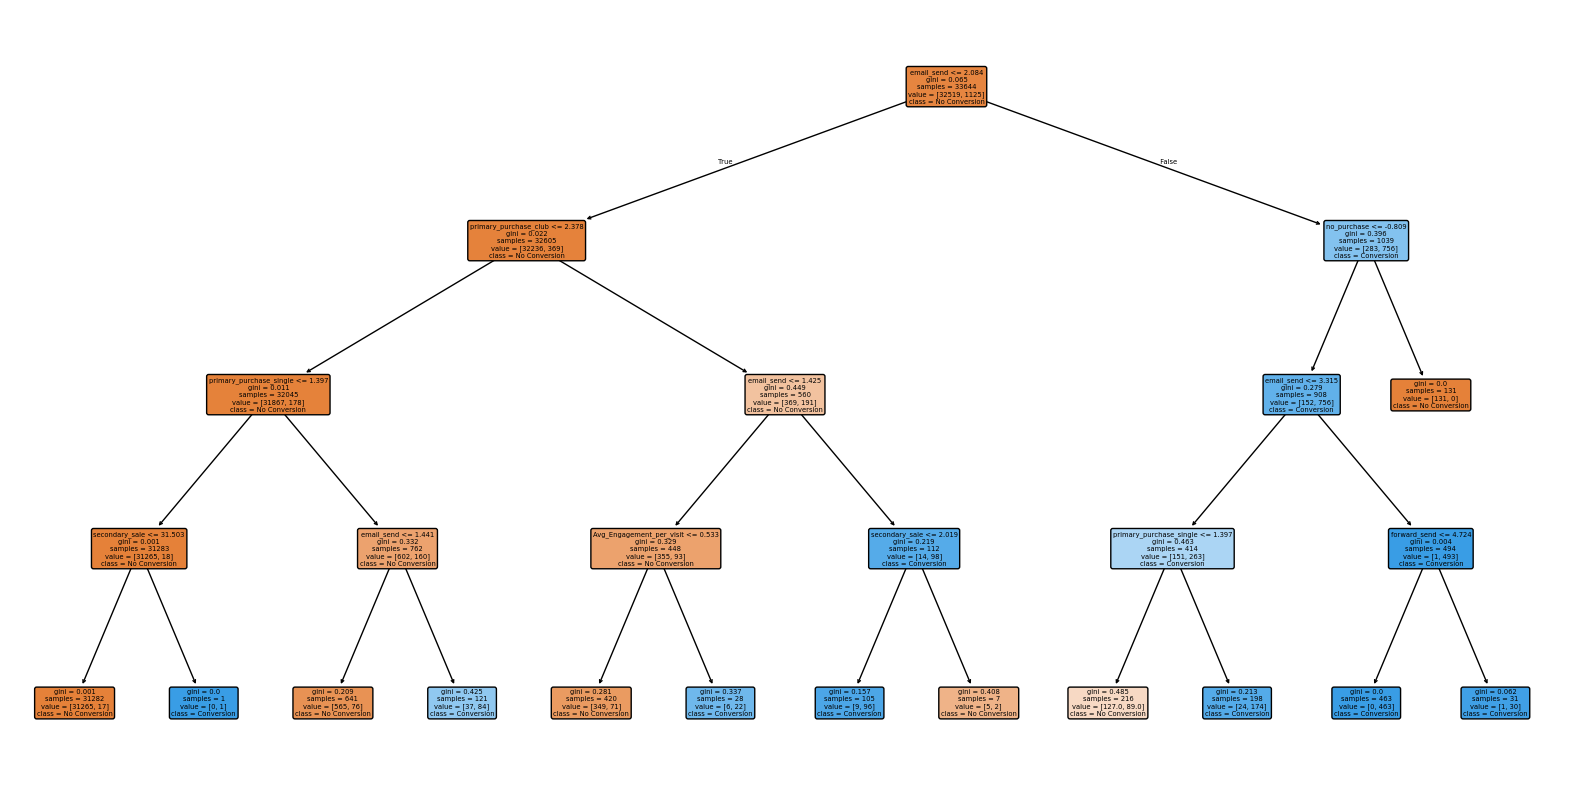

In [50]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the Decision Tree from the pipeline
tree_model = tree_grid.best_estimator_.named_steps['regressor']

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, class_names=["No Conversion", "Conversion"], filled=True, rounded=True)
plt.show()


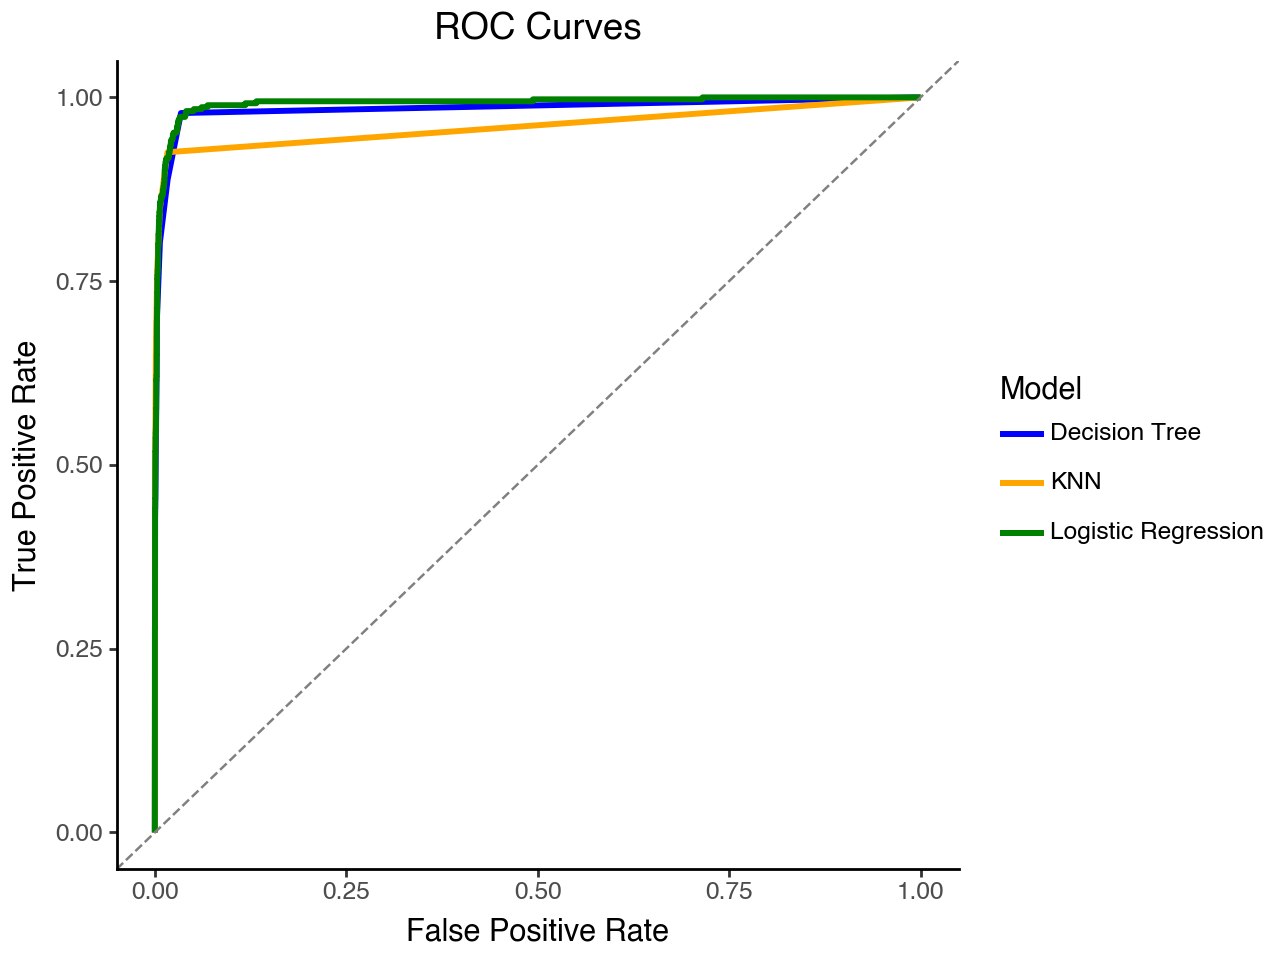

In [54]:
roc_data = []
for model, name in zip([knn_grid, logreg_grid, tree_grid], ['KNN', 'Logistic Regression', 'Decision Tree']):
    y_probs = model.best_estimator_.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_data.append(pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'model': name}))

roc_df = pd.concat(roc_data)

# Plot ROC Curves using ggplot
roc_plot = (
    ggplot(roc_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line(size=1.2) +
    geom_abline(linetype='dashed', color='gray') +
    labs(
        title='ROC Curve Comparison',
        x='False Positive Rate',
        y='True Positive Rate',
        color='Model'
    ) +
    theme_classic() +
    ggtitle("ROC Curves") +
    scale_color_manual(values=['blue', 'orange', 'green'])
)
roc_plot.show()